# GDM via Differentiable Programming

In this simulation we use a **differentiable programming** approach to solve the problem of **consensus reaching** in **group-decision making** (GDM). GDM studies the problem of aggregating the opinions of many experts/agents and the dynamics required to reach a consensus. Differentiable programming (also known as *software 2.0*) offers a novel approach to coding, focused on defining parametrized differentiable model to solve a problem instead of coding a precise algorithm (for a neat presentation of this paradigm, see, for instance [1]). 

In this notebook, we first define a model for aggregating preferences, and then we use differentiable programming to compute an optimal change to the original preferences that would lead to a consensus.

In this simulation we will use a simple model, but we will underline how this can be easily extended.

## 1. Problem Statement

A set of $M$ experts/agents provided us with evaluations over a set of $N$ choices/options. Evaluations are expressed as the degree of preference of one option over another. Preferences are quantified as real number in the interval $(0,1)$. For simplicity, we make the assumption that all pairs of options have a preference specified, and that the preferences expressed by an expert are consistent.

We consider three related problems: (i) Given the pairwise preferences for an expert, how can we define a ranking for his/her choices? (ii) Given the pairwise preferences for all the experts, how can we define a global consensus ranking for the available choices? (iii) How are the pairwise preferences of each expert supposed to be changed in order to converge to the global consensus ranking?

## 2. Model

We assume that the data is given in the form of a tensor $X$ with dimensions $N \times N \times M$, where $N$ is the number of choices/options and $M$ is the number of experts/agents. A slice $X[:,:,i]$ of this tensor is a matrix of dimension $N \times N$ encoding the pairwise prefereces of the i-th expert.

### Individual Aggregation
In order to produce a ranking for each expert (Problem (i)), we need an *aggregation function f over the choices* which, for every expert, reduces the matrix of pairwise preferences to a ranking vector:
$$
f: \mathbb{R}^{N \times N \times M} \rightarrow \mathbb{R}^{N \times M}.
$$

### Global Aggregation
In order to generate a final global consensus (Problem (ii)), we need to produce a final ranking $r$ of dimension $N$. To do this, we define an *aggregation function g over the experts* which aggregates together the rankings of the experts:
$$
g: \mathbb{R}^{N \times M} \rightarrow \mathbb{R}^{N}.
$$

### Aggregation Model
We compose the functions $f$ and $g$ in our aggregation model:
$$
g \circ f: \mathbb{R}^{N \times N \times M} \rightarrow \mathbb{R}^{N}.
$$
For simplicity, here we will take $f$ and $g$ to be simple averages. Notice, however, that these functions can be changed to whatever function we want, as long as they are differentiable.

### Consensus 
In order to evaluate the change in individual preferences (Problem (iii)), we express the *change for consensus* as a tensor $W$ of dimension $N \times N \times M$. We then redefine our aggregation model as:
$$
r = g(f(X+W))
$$
Notice that $W$ is applied in an addittive way, but this may changed (for instance, being multiplicative), and more structure may be imposed on it (for instance, requiring $W$ to be symmetric).

### Loss function 
We now formulate an optimization problem requiring to learn a consensus that would require a *minimal* change in the individual preferences. To do this, we define the following loss to be minimized:
$$
\mathcal{L} = \left\| r - f(X+W) \right\|_2.
$$
This loss evaluates the 2-norm of the difference between the final consensus and the ranking proposed by each expert. Notice that this loss can easily be changed to other $p$-norms, to a different loss altogether, or that it can be enriched with a regularization term.

## 3. Implementation

### Importing Libraries

Importing standard libraries and the following modules:
- *datagenerator.py*: containing data sources;
- *aggregationlib.py*: containing functions to perform aggregations.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import datagenerator as data
import normalizationlib as normlib
import aggregationlib as agglib

### Loading the data

We load the data taken from a paper by Viedma et al. [2], and we normalize it. (Normalization can arbitrarily change).

In [7]:
X = data.get_PREF_tensor_Viedma1()
X = normlib.normalize_by_column_tensor(X).astype('float32')

n_choices = X.shape[0]
n_experts = X.shape[2]

### Defining the loss function
We define the loss as the $\ell_2$-norm between the matrix $R$ containing the ranking of each expert and the aggregate ranking $r$. This loss function gives us a measure of the distance of each expert from the collective aggregated solution $r$. 
(Loss function can arbitrarily change).

In [8]:
def L2loss(R,r):
    rr = tf.reshape(r,(r.shape[0],1))
    return tf.norm(R-rr, ord=2)

### Implemeting the model
We define the model explained above $r = g(f(X+W))$, where both $f$ and $g$ are simple averages (*tf.reduce_mean*). The framework for differentiable programming takes care of computing $\frac{\partial\mathcal{L}}{\partial W}$. We then learn with a learning step $\epsilon = 0.005$.
(Aggregation functions $f$ and $g$ and step $\epsilon$ can arbitrarily change).

In [9]:
learning_step = 0.005
W = tf.Variable(tf.zeros((n_choices,n_choices,n_experts), dtype='float32'))

def step(X):
    with tf.GradientTape(persistent=True) as tape:
        XX = X + W
        R = tf.reduce_mean(XX,axis=1)
        r = tf.reduce_mean(R,axis=1)
        
        loss = L2loss(R,r)
        
    W_grad = tape.gradient(loss,W)
    W.assign_sub(W_grad*learning_step)

### Running the model
We finally run the model for $500$ iterations to learn the value of $W$.
(Number of iterations can arbitrarily change).

In [10]:
for _ in range(500):
    step(X)

## 4. Analysis of the Results

### Analysis of the original data
We first take a look at the original data; in particular, we visualize what is the ranking of the options among the experts at the beginning.

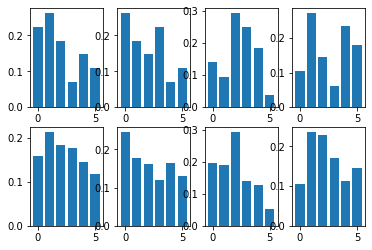

In [11]:
R = tf.reduce_mean(X,axis=1)

for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.bar(np.arange(6),R[:,i])

We observe that experts have different rankings among them; for instance some place the first option as the best alternative, some favour the second option, some opt for the third.

### Analysis of the data after learning
We now look at the data after each expert has reviewed his/her opinion as computed by the matrix $W$.

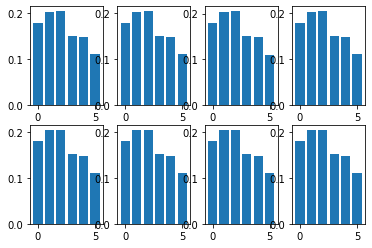

In [12]:
R = tf.reduce_mean(X+W,axis=1)

for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.bar(np.arange(6),R[:,i])

Now all the experts converge to the same ranking.

Let us also visualize the type of changes imposed by $W$.

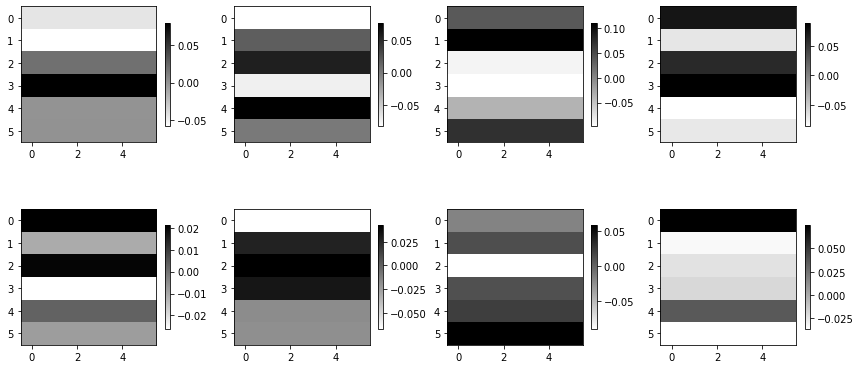

In [13]:
plt.figure(figsize=(12,6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    im = plt.imshow(W[:,:,i],cmap='binary')
    cbar = plt.colorbar(im,shrink=.5)
plt.tight_layout()

We notice that the solution found by this simple algorithm relies on increasing/decreasing the value of certain choices of a fixed amount wrt to all the other options (black means increasing a preference, white means decreasing preference).

Notice that these changes may violate the original consistency of the preferences expressed by each individual expert.

## 5. Alternative Models
We consider a couple of alternative implementations and check the results.

### Symmetric changes
We reimplement the same model, this time forcing $W$ to be symmetric.

In [14]:
def L2loss(R,r):
    rr = tf.reshape(r,(r.shape[0],1))
    return tf.norm(R-rr, ord=2)

learning_step = 0.005
W = tf.Variable(tf.zeros((n_choices,n_choices,n_experts), dtype='float32'))

def step(X):
    with tf.GradientTape(persistent=True) as tape:
        
        symW = 0.5*(W + tf.transpose(W,perm=[1,0,2]))
        XX = X + symW
        R = tf.reduce_mean(XX,axis=1)
        r = tf.reduce_mean(R,axis=1)
        
        loss = L2loss(R,r)
        
    W_grad = tape.gradient(loss,W)
    W.assign_sub(W_grad*learning_step)
    
for _ in range(1000):
    step(X)

We plot the individual ranking after the correction for consensus.

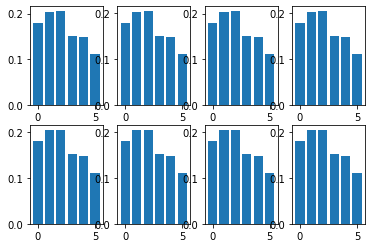

In [15]:
symW = 0.5*(W + tf.transpose(W,perm=[1,0,2]))
R = tf.reduce_mean(X+symW,axis=1)

for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.bar(np.arange(6),R[:,i])

Consensus reached. We now plot the correction for consensus.

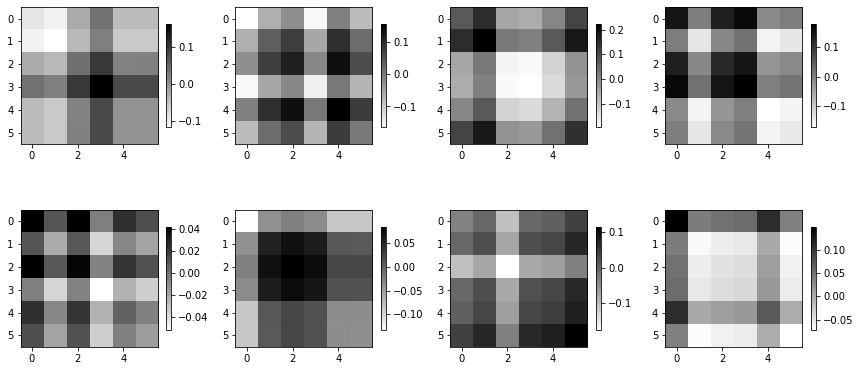

In [16]:
symW = 0.5*(W + tf.transpose(W,perm=[1,0,2]))

plt.figure(figsize=(12,6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    im = plt.imshow(symW[:,:,i],cmap='binary')
    cbar = plt.colorbar(im,shrink=.5)
plt.tight_layout()

Now changes are symmetric. The result is formally correct, although it may practically make little sense (anti-symmetry may be of more interest).

### Noisy initialization
Instead of initiliazing $W$ to zero we now initialize with random Gaussian noise, to represent the fact that the estimations of the experts are not precise. This add some stochasticity and allows us to run the algorithm with different initializations. We reimplement the model forcing $W$ to be Gaussian.

In [17]:
def L2loss(R,r):
    rr = tf.reshape(r,(r.shape[0],1))
    return tf.norm(R-rr, ord=2)

learning_step = 0.005
W = tf.Variable(tf.random.normal((n_choices,n_choices,n_experts), mean=0.0, stddev=.05, dtype='float32'))

def step(X):
    with tf.GradientTape(persistent=True) as tape:
        
        XX = X + W
        R = tf.reduce_mean(XX,axis=1)
        r = tf.reduce_mean(R,axis=1)
        
        loss = L2loss(R,r)
        
    W_grad = tape.gradient(loss,W)
    W.assign_sub(W_grad*learning_step)
    
for _ in range(1000):
    step(X)

We plot the individual ranking after the correction for consensus.

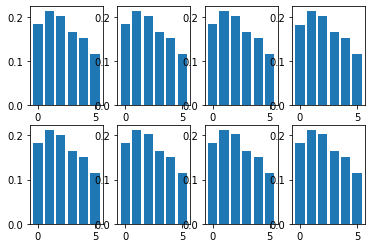

In [18]:
R = tf.reduce_mean(X+W,axis=1)

for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.bar(np.arange(6),R[:,i])

Consensus (different from before!) reached. We now plot the correction for consensus.

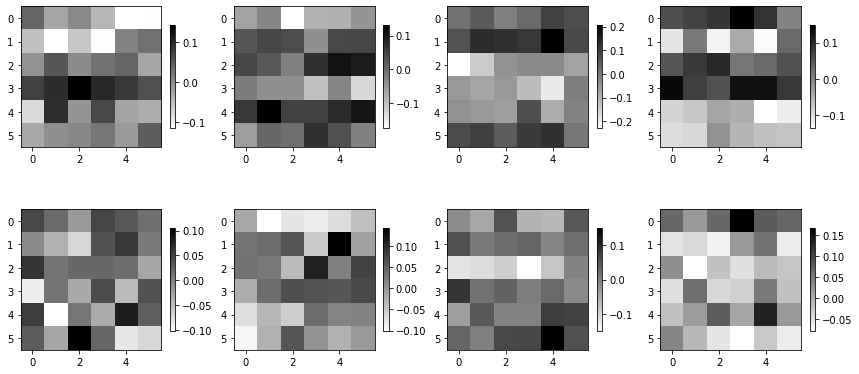

In [19]:
plt.figure(figsize=(12,6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    im = plt.imshow(W[:,:,i],cmap='binary')
    cbar = plt.colorbar(im,shrink=.5)
plt.tight_layout()

Changes are now more uneven.

### Adding regularization
We add now a L1 regularization on $W$ in order to favour sparsity in our solution.

In [20]:
def L2loss(R,r):
    rr = tf.reshape(r,(r.shape[0],1))
    return tf.norm(R-rr, ord=2)

def L1loss(W):
    return tf.norm(W,ord=1)

alpha = .5
learning_step = 0.005
W = tf.Variable(tf.random.normal((n_choices,n_choices,n_experts), mean=0.0, stddev=.05, dtype='float32'))

def step(X):
    with tf.GradientTape(persistent=True) as tape:
        
        XX = X + W
        R = tf.reduce_mean(XX,axis=1)
        r = tf.reduce_mean(R,axis=1)
        
        loss = L2loss(R,r) + alpha*L1loss(W)
        
    W_grad = tape.gradient(loss,W)
    W.assign_sub(W_grad*learning_step)
    
for _ in range(1000):
    step(X)

We plot the individual ranking after the correction for consensus.

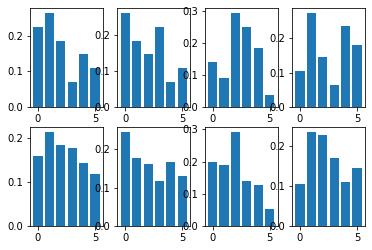

In [21]:
R = tf.reduce_mean(X+W,axis=1)

for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.bar(np.arange(6),R[:,i])

Consensus is harder to reach with a loss function with two terms. Scaling down $\alpha$ may help reaching a consensus.

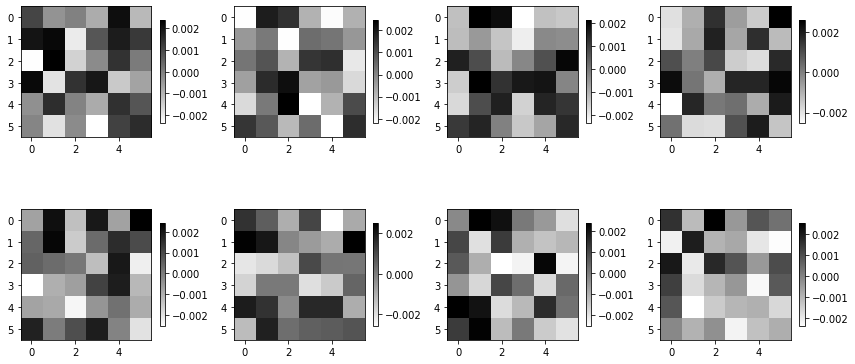

In [22]:
plt.figure(figsize=(12,6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    im = plt.imshow(W[:,:,i],cmap='binary')
    cbar = plt.colorbar(im,shrink=.5)
plt.tight_layout()

And indeed we notice some more sparsity on the weights.

## 6. Conclusions

*GDM* provided an interesting problem where to apply *differentiable programming*. Conversely, *GDM* may take advantage of the versatile and optimized, although black-box, solution provided by *differentiable programming*.

### References

[1] https://towardsdatascience.com/deep-learning-from-a-programmers-perspective-aka-differentiable-programming-ec6e8d1b7c60

[2] Herrera-Viedma, E., Herrera, F. and Chiclana, F., 2002. A consensus model for multiperson decision making with different preference structures. IEEE Transactions on Systems, Man, and Cybernetics-Part A: Systems and Humans, 32(3), pp.394-402.